In [1]:
using LinearAlgebra
using SparseArrays
using Statistics
import Laplacians as Lap
include("Laplacians.jl/src/Laplacians.jl")
import .Laplacians as LapM
import Random
using Plots
using BenchmarkTools
using CUDA
using Graphs
using SNAPDatasets
using GraphIO
using PProf

| Name | Category | Nodes | Edges | Description | link (from snap) |
| --- | --- | --- | --- | --- | --- |
| email-enron.txt | communication | 33696 | 361622 | Email communication network from Enron | data/email-Enron.html |
| soc-LiveJournal1.txt | social network | 4843953 | 85691368 | LiveJournal online social network | data/soc-LiveJournal1.html |
| web-Google.txt | Web graphs | 855802 | 8582704 | Nodes represent web pages and directed edges represent hyperlinks between them. | data/web-Google.html |
| wiki-Talk.txt | communication | 2388953 | 9313364 | Wikipedia talk (communication) network | data/wiki-Talk.html |

In [2]:
GraphNames = ["email-Enron.txt", "soc-LiveJournal1.txt", "web-Google.txt", "wiki-Talk.txt"] # four types of graph from SNAP
GraphPaths = [ "graph/" * s for s in GraphNames]

4-element Vector{String}:
 "graph/email-Enron.txt"
 "graph/soc-LiveJournal1.txt"
 "graph/web-Google.txt"
 "graph/wiki-Talk.txt"

In [3]:
# a structure for the analyze result
struct AnalysisResult
    ldli
    levelSets
    avgwds
    works
    cumworks
    opsLevel
end

In [4]:
function loadGraphAdj(path)
    g = loadgraph(path, "graph_key", EdgeListFormat())
    g = SimpleGraph(g)
    g = induced_subgraph(g, connected_components(g)[1])[1]
    G = Float64.(sparse(SimpleGraph(g)))
    for i in 1:size(G, 1)
        G[i, i] = 0
    end
    dropzeros!(G)
    return g, G
end

# get the ldli for that graph
function getldli(G)
    lapG = Lap.lap(G)
    ldliG = Lap.approxChol(Lap.LLmatp(G))
    
    return lapG, ldliG
end

# the analyzer
function analyzeForward(ldli)
    levelSets = Vector{Vector{Int64}}(undef, 0)
    numLevels = 0

    count = zeros(Int64, size(ldli.col, 1) + 1) # each entry for a row entry
    levels = ones(Int64, size(ldli.col, 1) + 1) # each entry for a row entry, all start with level 1
    
    backptr = similar(ldli.rowval) # generate reverse pointer pointing back to 

    for it in 1:length(ldli.col)
        i = ldli.col[it]
    
        j0 = ldli.colptr[it]
        j1 = ldli.colptr[it + 1] - 1
        
        for up in j0:j1
            uprow = ldli.rowval[up]
            if uprow != i # self edge should not count
                count[uprow] = count[uprow] + 1 # following iteration that depends need another update
                levels[uprow] = max(levels[uprow], levels[i] + 1)
            end
            backptr[up] = it # pointing back to the iteration index
        end
        
        if levels[i] > numLevels
            numLevels = numLevels + 1
            push!(levelSets, [it]) # push the iteration number
        else
            push!(levelSets[levels[i]], it) # push the iteration number
        end
    end
    
    return levelSets, numLevels, count, backptr
end

# parallelism
function parallelismInLDLi(ldli, levelSets)
    avgwds = Float64[] # the average size of the inner loop
    works = Int64[] # the total works avaialbe in an level
    tworks = 0
    cumworks = Int64[] # the integral of works
    for level in levelSets
        wds = [ldli.colptr[i + 1] - ldli.colptr[i] for i in level]
        push!(avgwds, mean(wds))
        push!(works, sum(wds))
        tworks += sum(wds)
        push!(cumworks, tworks)
    end
    
    return avgwds, works, cumworks
end



function analyzeGraph(g, G)
    lapG, ldliG = getldli(G)
    levelSets, numLevels, count, backptr = analyzeForward(ldliG)
    avgwds, works, cumworks = parallelismInLDLi(ldliG, levelSets)
    
    opsLevel = [length(level) for level in levelSets]
    
    return AnalysisResult(ldliG, levelSets, avgwds, works, cumworks, opsLevel)
end

analyzeGraph (generic function with 1 method)

Load Graphs

In [5]:
graphs = Dict{String, Any}()
for graph in GraphNames
    graphpath = "graph/" * graph
    g, G = loadGraphAdj(graphpath)
    graphs[graph] = (g, G)
end

Start analyzing

In [6]:
analysisRes = Dict{String, AnalysisResult}()
for graph in GraphNames
    g, G = graphs[graph]
    
    res = analyzeGraph(g, G)
    analysisRes[graph] = res
end

The number of iterations at each level. y axis is normalized to its maximum and x axis is normalized to 100%

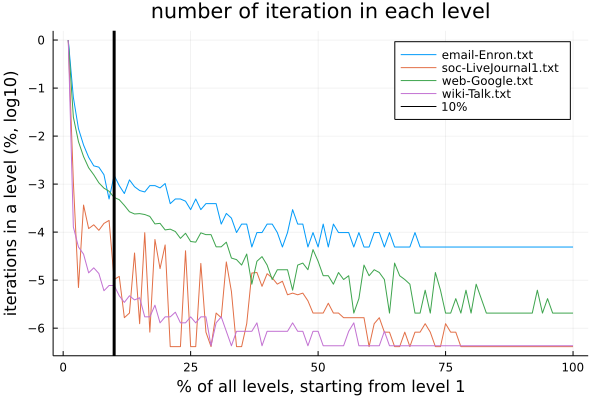

In [103]:
allOpsLevelNormalized = []
for graph in GraphNames
    res = analysisRes[graph]
    
    opsLevel = res.opsLevel
    opsLevel = opsLevel ./ maximum(opsLevel)
    opsLevel = [opsLevel[floor(Int64, i)] for i in range(start=1, stop=length(opsLevel), length = 100)]
    push!(allOpsLevelNormalized, log10.(opsLevel))
end
plot(1:100, allOpsLevelNormalized, label = reshape(GraphNames, (1, length(GraphNames))), 
    ylabel = "iterations in a level (%, log10)", xlabel = "% of all levels, starting from level 1",
    title = "number of iteration in each level")
vline!([10], label = "10%", width=3, color = :black)

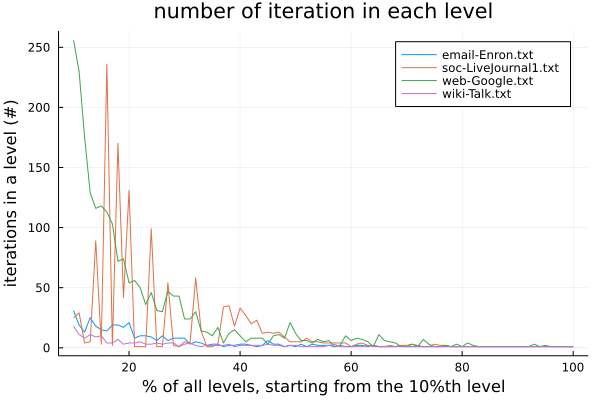

In [104]:
allOpsLevel90 = []
for graph in GraphNames
    res = analysisRes[graph]
    
    opsLevel = res.opsLevel
    opsLevel = [opsLevel[floor(Int64, i)] for i in range(start=1, stop=length(opsLevel), length = 100)]
    push!(allOpsLevel90, opsLevel[10:100])
end
plot(10:100, allOpsLevel90, label = reshape(GraphNames, (1, length(GraphNames))), 
    ylabel = "iterations in a level (#)", xlabel = "% of all levels, starting from the 10%th level",
    title = "number of iteration in each level")
    

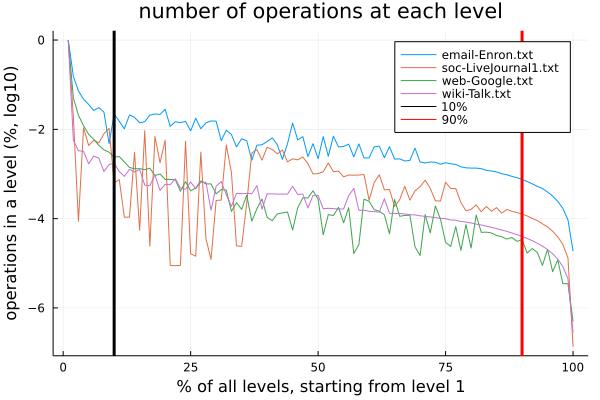

In [67]:
allWorksNormalized = []
for graph in GraphNames
    res = analysisRes[graph]
    
    works = res.works
    works = works ./ maximum(works)
    works = [works[floor(Int64, i)] for i in range(start=1, stop=length(works), length = 100)]
    push!(allWorksNormalized, log10.(works))
end
plot(1:100, allWorksNormalized, label = reshape(GraphNames, (1, length(GraphNames))), 
    ylabel = "operations in a level (%, log10)", xlabel = "% of all levels, starting from level 1",
    title = "number of operations at each level", legend=:best)
vline!([10], label = "10%", width=3, color = :black)
vline!([90], label = "90%", width=3, color = :red)

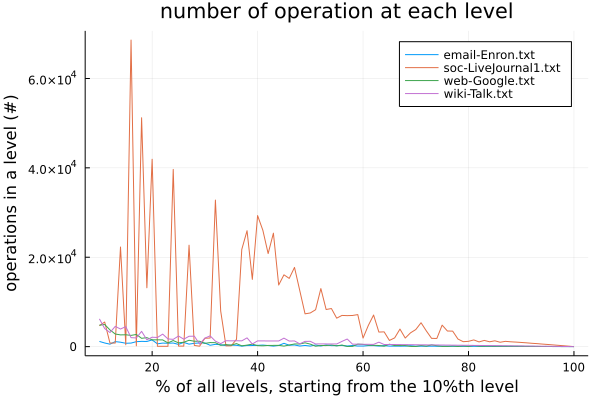

In [102]:
allworks90 = []
for graph in GraphNames
    res = analysisRes[graph]
    
    works = res.works
    works = [works[floor(Int64, i)] for i in range(start=1, stop=length(works), length = 100)]
    push!(allworks90, works[10:100])
end
plot(10:100, allworks90, label = reshape(GraphNames, (1, length(GraphNames))), 
    ylabel = "operations in a level (#)", xlabel = "% of all levels, starting from the 10%th level",
    title = "number of operation at each level")

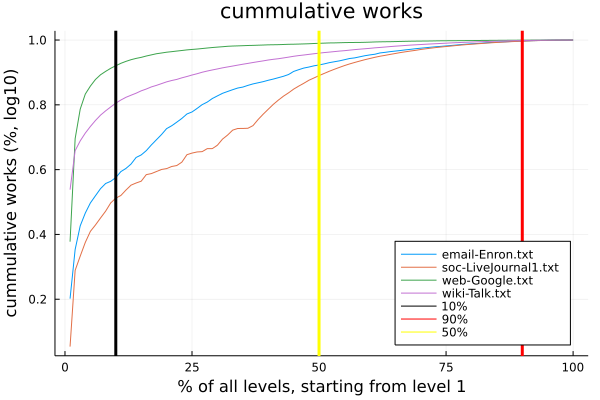

In [101]:
allcumworksNormalized = []
for graph in GraphNames
    res = analysisRes[graph]
    
    cumworks = res.cumworks
    cumworks = cumworks ./ maximum(cumworks)
    cumworks = [cumworks[floor(Int64, i)] for i in range(start=1, stop=length(cumworks), length = 100)]
    push!(allcumworksNormalized, cumworks)
end
plot(1:100, allcumworksNormalized, label = reshape(GraphNames, (1, length(GraphNames))), 
    ylabel = "cummulative works (%, log10)", xlabel = "% of all levels, starting from level 1",
    title = "cummulative works", legend = :bottomright)
vline!([10], label = "10%", width=3, color = :black)
vline!([90], label = "90%", width=3, color = :red)
vline!([50], label = "50%", width=3, color = :yellow)

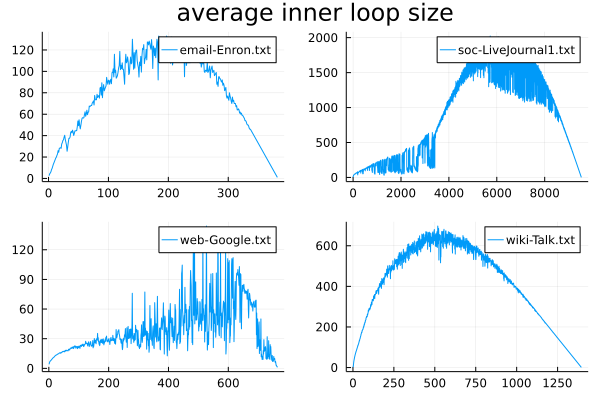

In [98]:
plots = []
for graph in GraphNames
    push!(plots, plot(analysisRes[graph].avgwds, label = graph))
end
plot(plots..., plot_title = "average inner loop size")